<a href="https://colab.research.google.com/github/Next-Sunshine/TTF0318/blob/master/federated_learning_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@test {"skip:true"}
!pip install --quiet --upgrade tensorflow_federated

     |████████████████████████████████| 430kB 2.7MB/s 
     |████████████████████████████████| 20.0MB 1.6MB/s 
     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.9MB 58.1MB/s 
     |████████████████████████████████| 450kB 59.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello,world!')()

b'Hello,world!'

In [3]:
#装载数据集
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

97402880/97398400 [==============================] - 1s 0us/step


In [6]:
len(emnist_train.client_ids)

3383

In [7]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [11]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)
example_element = next(iter(example_dataset))
example_element['label'].numpy()

5

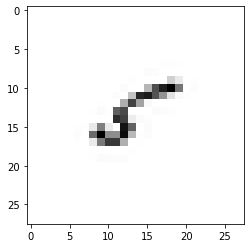

In [13]:
from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_=plt.show()

In [0]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):
  def batch_format_fn(element):
    #Flatten a batch 'pixels' and return the features as an 'OrderedDict'
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1,784]),
        y = tf.reshape(element['label'], [-1,1])
    )
  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [15]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[8],
                     [0],
                     [5],
                     [6],
                     [6],
                     [7],
                     [0],
                     [3],
                     [1],
                     [1],
                     [5],
                     [2],
                     [7],
                     [0],
                     [2],
                     [9],
                     [0],
                     [2],
                     [2],
                     [3]], dtype=int32))])

In [0]:
def make_federated_data(client_data, client_ids):
  return [
          preprocess(client_data.create_tf_dataset_for_client(x))
          for x in client_ids
  ]

In [27]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)


print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


In [0]:
def create_keras_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (784,)),
    tf.ketas.layers.Dense(10, kernel_initializer='zeros'),
    tf.keras.layers.Softmax(),
  ])